Collecting data.

Retrieve agent birth and exiting timestamp for potential indicators of system efficiency.

Additionally, collect the number of agents at each timestamp.

__Note that I did not remove agents from the Scheduler so that I can collect data for it__

09-04-2017

<hr>

In [8]:
import warnings
from itertools import product

In [9]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cityblock

In [1]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import BaseScheduler

In [25]:
from mesa.datacollection import DataCollector

In [56]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [146]:
def countAgentsOnBoard(model):
    '''Count the # of agents on a board'''
    return sum([not model.grid.is_cell_empty(cell[1:]) \
                for cell in model.grid.coord_iter()])

<hr>

In [147]:
class MyActivation(BaseScheduler):
    ''' A customized activation scheduler to move agents simultaneously and break ties randomly. '''

    def break_ties(self):
        ''' Break ties randomly'''
        for agent in self.agents[:]:
            if agent.exitday is None:
                agent.find_newPos()
            
        agent_pos_df = pd.DataFrame([(agent, agent.newPos) for agent in self.agents[:]],
                                    columns=['agent', 'newPos'])
        for newPos, df in agent_pos_df.groupby('newPos'):
            ''' randomly select one agent to move the that `newPos`'''
            selected_agent = df.agent[np.random.choice(df.agent.index)]
            for agent in df.agent:
                if agent is selected_agent:
                    continue
                ## agents not selected will stay put
                ## by setting `newPos` to `None`.
                agent.newPos = None
            print(newPos, [item.unique_id for item in df.agent], selected_agent.unique_id, 
                  [(item.unique_id, item.pos, item.newPos) for item in df.agent if item != selected_agent])
    
    def check_availability(self):
        '''Check if agents' `newPos` are available'''
        for agent in self.agents[:]:
            if agent.newPos is None:
                continue
            ## for those who are going to move, check if their future `dest` is available
            newPos_content_list = agent.model.grid.get_cell_list_contents(agent.newPos)
            for newPos_content in newPos_content_list:
                if newPos_content.newPos is None:
                    ## if it cannot move, reset `newPos`
                    agent.newPos = None
                    break
            print(agent.unique_id, agent.pos, agent.newPos, 
                  [(a.unique_id, a.pos, a.newPos) for a in newPos_content_list])

    def check_avail_wrapper(self):
        '''Due to the problem of synchronization, repeat doing this until converges'''
        converge = False
        last_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
        while not converge:
            self.check_availability()
            this_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
            if np.array_equal(this_newPos_array, last_newPos_array):
                converge = True
            last_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
            
    def step(self):
        self.break_ties()
        self.check_avail_wrapper()
        for agent in self.agents[:]:
            if agent.exitday is None:
                agent.step()

<hr>

#### Agent and model class

In [148]:
class CheckerAgent(Agent):
    '''
        A checker on the board showing on the left-most column
        and trying to go to the right-most column.

        Attributes
        ----------
        aid : the index among all agents born at timestamp `tid`
        model: the board that an agent will be in
        dest: destination
        birthday: the timestamp when an agent shows up in the left-most column
        exitday: the timestamp when an agent arrives at its `dest`
    '''
    def __init__(self, aid, model, dest, birthday):
        super().__init__(aid, model)
        self.dest = dest
        self.newPos = None
        self.birthday = birthday
        self.exitday = None

    def find_newPos(self):
        current_dist = cityblock(self.pos, self.dest)
        possible_move_positions = list()
        for neighbor in self.model.grid.iter_neighborhood(self.pos, False):
            ## distance between the neighbor and its destination
            _dist = cityblock(neighbor, self.dest)
            if _dist < current_dist:
                #possible_move_positions.append((neighbor, 
                #                                self.model.grid.is_cell_empty(neighbor)))
                possible_move_positions.append(neighbor)
        ## randomly pick one direction to proceed to `dest` without prior knowledge.
        self.newPos = possible_move_positions[np.random.choice(len(possible_move_positions))]

    def step(self):
        if self.newPos is not None:
            self.model.grid.move_agent(self, self.newPos)
        if self.pos == self.dest:
            ## upon arrival, remove itself from the grid
            self.model.grid.remove_agent(self)
            #self.model.schedule.remove(self)
            self.exitday = self.model.timestamp
            print('Agent %d exits at time %d'%(self.unique_id, self.exitday))

##### Board model modified

Add `DataCollector` to the model.

In [149]:
class CheckerBoardModel(Model):
    '''
        A checker board bearing the agents.
        Each time step, a constant of agents will be added to the left-most column if avaialble.

        Attributes
        ----------
        aid : the index among all agents born at timestamp `tid`
        numAgents : the number of agents generated at each timestamp
        boardSize : the width and height of the grid
        schedule : the scheduler to use
        timestamp : the current timestamp (starts at 0)
    '''
    def __init__(self, numAgents, boardSize, seed=None):
        super().__init__(seed)
        ## number of agents
        if numAgents > boardSize:
            warnings.warn("# of agents is larger than the board size! Use board size %d as the number of agents"%boardSize,
                           RuntimeWarning)
            numAgents = boardSize
        self.numAgents = np.min((numAgents, boardSize))
        ## Not toroidial: cannot go across the border.
        self.grid = MultiGrid(boardSize, boardSize, False)
        self.schedule = MyActivation(self)
        self.timestamp = 0
        #self.cellCoords = list(product(np.arange(self.grid.width), 
        #                                np.arange(self.grid.width)))
        self.datacollector = DataCollector(
                                           model_reporters={"agentsOnBoard": countAgentsOnBoard},
                                           agent_reporters={'birthday': lambda a: a.birthday,
                                                            'exitday': lambda a: a.exitday}
                                          )
        #print('Current timestamp %d'%self.timestamp)
        ## Create agents
        for i in np.arange(self.numAgents):
            a = CheckerAgent(aid=i+1,
                             model=self,
                             birthday = self.timestamp,
                             dest=(boardSize-1,
                                   np.random.choice(self.grid.width)))
            ## destinations are sampled on the right-most column
            self.schedule.add(a)
            ## place they on the left-most column
            while True:
                xi = np.random.choice(self.grid.width)
                if self.grid.is_cell_empty((0, xi)):
                    self.grid.place_agent(a, (0, xi))
                    a.newPos = (0, xi)
                    break
                else:
                    continue
            
    def generate_new_agents(self):
        '''Generate new agents to the board if avaialble, AFTER step function'''
        ## check left-most columns availability
        available_cells = [xi for xi in np.arange(self.grid.width) \
                           if self.grid.is_cell_empty((0, xi))]
        numNewAgents = np.min((len(available_cells), self.numAgents))
        ## if no available slots, do not generate new agents
        if numNewAgents < 1:
            return
        ## re-order the availabilities randomly
        random_indices = np.random.choice(range(len(available_cells)), 
                                          replace=False, 
                                          size=numNewAgents)
        available_cells = [available_cells[i] for i in random_indices]
                                                                        
        ## index of the emerging agents: current max + 1
        starting_idx = max([a.unique_id for a in self.schedule.agents[:]]) + 1
        ## randomly assign positions (for k agents, k is the min of board size and availability)
        for i in np.arange(len(available_cells)):
            a = CheckerAgent(aid=starting_idx+i,
                             model=self,
                             birthday=self.timestamp,
                             dest=(self.grid.width-1,
                                   np.random.choice(self.grid.width)))
            self.schedule.add(a)
            self.grid.place_agent(a, (0, available_cells[i]))
            
    def check_cell_content(self):
        '''Check if one cell contains more than one agent at one timestamp after `step` and `generate` is done.'''
        cell_agent_count = dict()
        for cell in self.grid.coord_iter():
            cell_agent_count[cell[1:]] = len(cell[0])
        violated_cells = [cell for cell in cell_agent_count 
                          if cell_agent_count[cell] > 1]
        if len(violated_cells) > 0:
            print(violated_cells)
            raise Exception('More than two agents on one cell')
                
        
    def step(self):
        '''Advance the model by one step.
        
            One step includes:
            1) Move existing nodes using scheduler
            2) Generate new agents
            3) increment timestamp
        '''
        self.datacollector.collect(self)
        self.schedule.step()
        self.generate_new_agents()
        self.timestamp += 1
        self.check_cell_content()
        print('Current timestamp %d'%self.timestamp)
        print('-----------------------------------')

#### Testing code

In [150]:
boardModel = CheckerBoardModel(2, 3, seed=np.random.randint(100))

##### Try to move the agents

In [151]:
for i in range(100):
    boardModel.step()

(1, 0) [2] 2 []
(1, 2) [1] 1 []
1 (0, 2) (1, 2) []
2 (0, 0) (1, 0) []
Current timestamp 1
-----------------------------------
(1, 1) [3] 3 []
(1, 2) [4] 4 []
(2, 0) [2] 2 []
(2, 2) [1] 1 []
1 (1, 2) (2, 2) []
2 (1, 0) (2, 0) []
3 (0, 1) (1, 1) []
4 (0, 2) (1, 2) [(1, (1, 2), (2, 2))]
Agent 1 exits at time 1
Current timestamp 2
-----------------------------------
(0, 1) [5] 5 []
(1, 1) [6] 6 []
(2, 1) [2, 3] 2 [(3, (1, 1), None)]
(2, 2) [1, 4] 1 [(4, (1, 2), None)]
1 None (2, 2) []
2 (2, 0) (2, 1) []
5 (0, 2) (0, 1) [(6, (0, 1), (1, 1))]
6 (0, 1) None [(3, (1, 1), None)]
1 None (2, 2) []
2 (2, 0) (2, 1) []
5 (0, 2) None [(6, (0, 1), None)]
1 None (2, 2) []
2 (2, 0) (2, 1) []
Current timestamp 3
-----------------------------------
(0, 1) [5] 5 []
(1, 0) [7] 7 []
(1, 1) [6] 6 []
(2, 1) [3] 3 []
(2, 2) [1, 2, 4] 2 [(1, None, None), (4, (1, 2), None)]
2 (2, 1) (2, 2) []
3 (1, 1) (2, 1) [(2, (2, 1), (2, 2))]
5 (0, 2) (0, 1) [(6, (0, 1), (1, 1))]
6 (0, 1) (1, 1) [(3, (1, 1), (2, 1))]
7 (0, 0)

12 (0, 2) (1, 2) [(10, (1, 2), (1, 1))]
14 (1, 1) (2, 1) [(16, (2, 1), (2, 2))]
16 (2, 1) (2, 2) []
17 None (2, 0) []
Agent 16 exits at time 25
Current timestamp 26
-----------------------------------
(0, 1) [19] 19 []
(0, 2) [20] 20 []
(1, 1) [18] 18 []
(1, 2) [11] 11 []
(2, 0) [17] 17 []
(2, 1) [10] 10 []
(2, 2) [12, 14, 16] 16 [(12, (1, 2), None), (14, (2, 1), None)]
10 (1, 1) None [(14, (2, 1), None)]
11 (0, 2) None [(12, (1, 2), None)]
16 None (2, 2) []
17 None (2, 0) []
18 (1, 0) None [(10, (1, 1), None)]
19 (0, 0) (0, 1) [(20, (0, 1), (0, 2))]
20 (0, 1) None [(11, (0, 2), None)]
16 None (2, 2) []
17 None (2, 0) []
19 (0, 0) None [(20, (0, 1), None)]
16 None (2, 2) []
17 None (2, 0) []
Current timestamp 27
-----------------------------------
(1, 0) [19] 19 []
(1, 1) [18, 20] 20 [(18, (1, 0), None)]
(1, 2) [11] 11 []
(2, 0) [17] 17 []
(2, 1) [10] 10 []
(2, 2) [12, 14, 16] 14 [(12, (1, 2), None), (16, None, None)]
10 (1, 1) (2, 1) [(14, (2, 1), (2, 2))]
11 (0, 2) None [(12, (1, 2),

(2, 1) [27, 30, 32] 30 [(27, (2, 0), None), (32, (1, 1), None)]
(2, 2) [33] 33 []
30 (2, 2) (2, 1) [(31, (2, 1), (2, 0))]
31 (2, 1) None [(27, (2, 0), None)]
33 (1, 2) (2, 2) [(30, (2, 2), (2, 1))]
34 (0, 1) None [(32, (1, 1), None)]
35 (0, 0) None [(28, (1, 0), None)]
36 (0, 2) (1, 2) [(33, (1, 2), (2, 2))]
30 (2, 2) None [(31, (2, 1), None)]
33 (1, 2) None [(30, (2, 2), None)]
36 (0, 2) None [(33, (1, 2), None)]
Current timestamp 56
-----------------------------------
(0, 0) [34] 34 []
(1, 0) [35] 35 []
(1, 2) [36] 36 []
(2, 0) [28, 31] 28 [(31, (2, 1), None)]
(2, 1) [27, 30, 32] 30 [(27, (2, 0), None), (32, (1, 1), None)]
(2, 2) [33] 33 []
28 (1, 0) None [(27, (2, 0), None)]
30 (2, 2) None [(31, (2, 1), None)]
33 (1, 2) None [(30, (2, 2), None)]
34 (0, 1) (0, 0) [(35, (0, 0), (1, 0))]
35 (0, 0) None [(28, (1, 0), None)]
36 (0, 2) None [(33, (1, 2), None)]
34 (0, 1) None [(35, (0, 0), None)]
Current timestamp 57
-----------------------------------
(0, 0) [34] 34 []
(1, 0) [35] 35 []


(1, 0) [52] 52 []
(1, 1) [51] 51 []
(1, 2) [55] 55 []
(2, 0) [49] 49 []
(2, 1) [44, 47] 44 [(47, (1, 1), None)]
(2, 2) [53, 54] 54 [(53, None, None)]
44 None (2, 1) []
49 None (2, 0) []
51 (0, 1) None [(47, (1, 1), None)]
52 (0, 0) (1, 0) []
54 (1, 2) (2, 2) []
55 (0, 2) (1, 2) [(54, (1, 2), (2, 2))]
44 None (2, 1) []
49 None (2, 0) []
52 (0, 0) (1, 0) []
54 (1, 2) (2, 2) []
55 (0, 2) (1, 2) [(54, (1, 2), (2, 2))]
Agent 54 exits at time 80
Current timestamp 81
-----------------------------------
(1, 0) [57] 57 []
(1, 1) [51, 55] 51 [(55, (1, 2), None)]
(1, 2) [56] 56 []
(2, 0) [49, 52] 49 [(52, (1, 0), None)]
(2, 1) [44, 47] 44 [(47, (1, 1), None)]
(2, 2) [54] 54 []
44 None (2, 1) []
49 None (2, 0) []
51 (0, 1) None [(47, (1, 1), None)]
54 None (2, 2) []
56 (0, 2) None [(55, (1, 2), None)]
57 (0, 0) None [(52, (1, 0), None)]
44 None (2, 1) []
49 None (2, 0) []
54 None (2, 2) []
Current timestamp 82
-----------------------------------
(0, 1) [57] 57 []
(1, 1) [51, 55] 51 [(55, (1, 2), N

##### Read data

###### Model data

In [152]:
model_data_df = boardModel.datacollector.get_model_vars_dataframe()
model_data_df.head()

agentsOnBoard
0              2
1              4
2              5
3              6
4              6

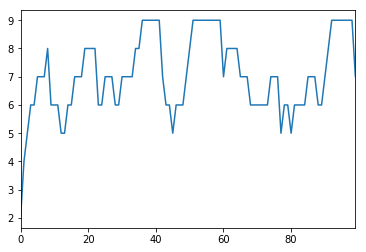

In [153]:
model_data_df.agentsOnBoard.plot()

###### Agent data

In [144]:
agent_data_df = boardModel.datacollector.get_agent_vars_dataframe()
agent_data_df.head()

birthday  exitday
Step AgentID                   
0    1               0      NaN
     2               0      NaN
1    1               0      NaN
     2               0      NaN
     3               0      NaN

In [79]:
agent_info_df = agent_data_df.query('Step==99')

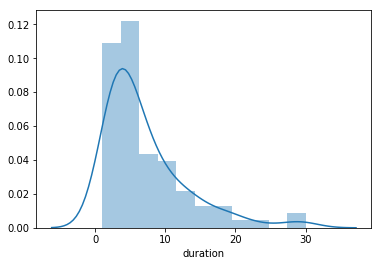

In [58]:
sns.distplot(agent_info_df.duration)

<hr>